In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.dpi' : 100,
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest'
})
from matplotlib.colors import LogNorm


# import adpr 
import adpr_utils
import model
import estimation
import jax.numpy as jnp
from jax import random

from poppy import zernike

# Model Setup

In [8]:
Np = 64 # pupil-plane sampling
Nf = 128 # focal-plane sampling
pix_m = 3.76e-6 # pixelscale in m

# bandpass
wave0 = 630e-9
bandwidth = 0.2
nwaves = 10
wavelengths = jnp.linspace(wave0-wave0*bandwidth/2.0, wave0+wave0*bandwidth/2.0, num=nwaves)
spectrum = jnp.linspace(1, 2, num=nwaves)

# f-number and defocus diversity (axial shift in m)
fnum = 15
dz = [-3.5e-3, -2.0e-3, 0.5e-3, 3.0e-3]

initialize forward model

In [9]:
# model = adpr.ForwardModel(Np, Nf, fnum, pix_m, wave0, wavelengths, dz, spectrum=spectrum)
mod = model.ForwardModel(Np, Nf, fnum, pix_m, wave0, wavelengths, dz, spectrum=spectrum)

# Simulate measured PSFs

In [4]:
type(pupil)

NameError: name 'pupil' is not defined

In [9]:
import cupy

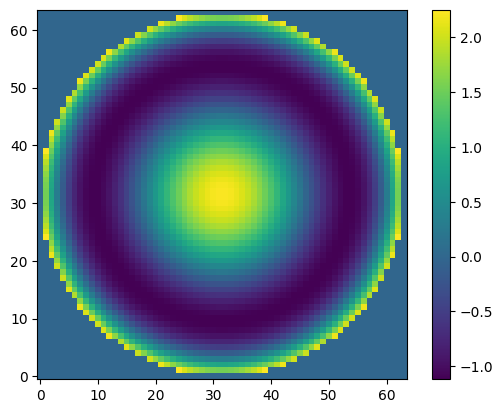

In [10]:
# monolithic circular pupil
pupil = adpr_utils.get_inscribed_circular_pupil(Np, upsample=1)
# use poppy to define zernikes
modes = jnp.array(zernike.arbitrary_basis(pupil, nterms=50, outside=0).get())[3:]
plt.imshow(modes[7])
plt.colorbar()

In [6]:
!nvidia-smi


Mon Apr 22 10:13:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   36C    P0             45W /  300W |      17MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

generate low-order OPD in m

In [11]:
nmodes = 20
rkey = random.PRNGKey(237)
opd_ab = jnp.sum(10e-9*random.normal(rkey,shape=(nmodes,))[:,None,None] * modes[:nmodes], axis=0)

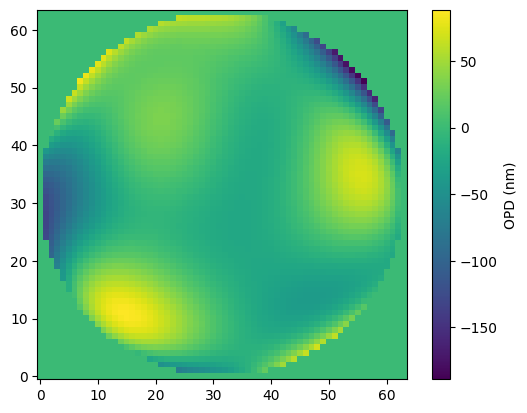

In [12]:
plt.imshow(opd_ab*1e9)
plt.colorbar().set_label('OPD (nm)')

use our `adpr` model to forward model the "measured" defocused PSFs

Note: due to the JIT compiler, this will run more quickly in subsequent calls

In [13]:
# %time psfs = adpr.forward_propagate(pupil, opd_ab, model.wavelengths, model.fresnel_TFs, model.Mx, model.My)
%time psfs = model.forward_propagate(pupil, opd_ab, mod.wavelengths, mod.fresnel_TFs, mod.Mx, mod.My)

CPU times: user 862 ms, sys: 258 ms, total: 1.12 s
Wall time: 599 ms


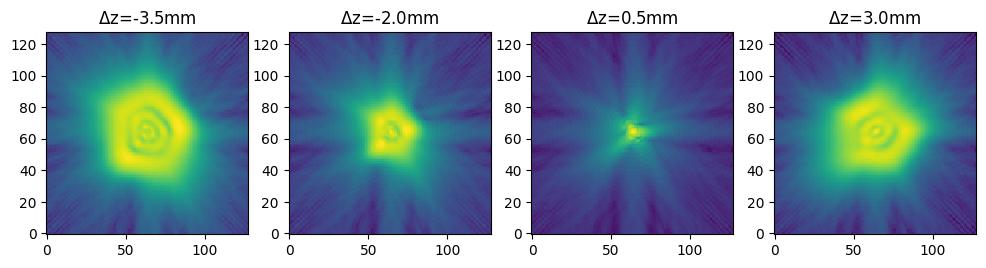

In [14]:
fig, axes = plt.subplots(1, len(dz), figsize=(12,3))

for i, ax in enumerate(axes):
    ax.imshow(psfs[i], norm=LogNorm())
    ax.set_title(f'$\Delta$z={dz[i]*1e3:.2}mm')

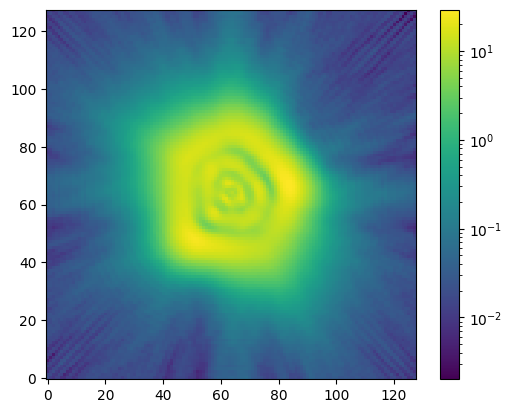

In [37]:
plt.imshow(psfs[0], norm=LogNorm())
plt.colorbar()

# Estimation

Simplest case: a pixel-by-pixel estimate of the phase, assuming a known pupil transmission function (amplitude)

In [15]:
# estimator = adpr.Estimation(model, estimate_phase=True, maxiter=100, wreg=1e-2)
estimator = estimation.Estimation(mod, estimate_phase=True, maxiter=100, wreg=1e-2)

In [16]:
fit, err, objvals = estimator.run(psfs, pupil)

2024-04-22 10:13:49.595130: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-04-22 10:13:50.025817: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-04-22 10:13:50.176870: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none
2024-04-22 10:13:50.466793: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 1.1975502575166725e-16 Stepsize:1.0  Decrease Error:0.0  Curvature Error:1.1975502575166725e-16 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.9312513949952008 Stepsize:1.0  Decrease Error:0.9312513949952008  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.930862993103268 Stepsize:0.49989723152549786  Decrease Error:0.930862993103268  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 0.9308688938032827 Stepsize:0.21116287315839097  Decrease Error:0.9308688938032827  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 0.9311964233527639 

2024-04-22 10:13:59.282583: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Err

Text(0, 0.5, 'objective function value')

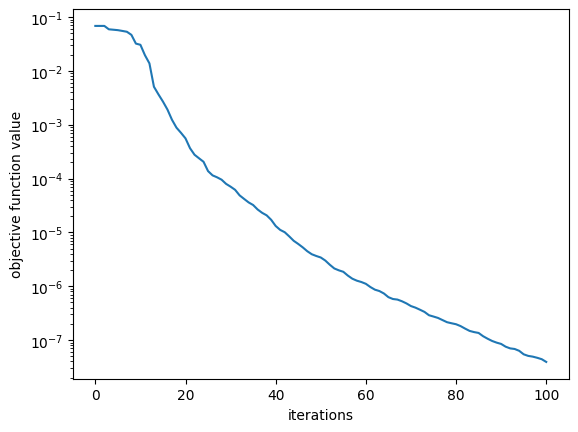

In [17]:
plt.semilogy(objvals)
plt.xlabel('iterations')
plt.ylabel('objective function value')

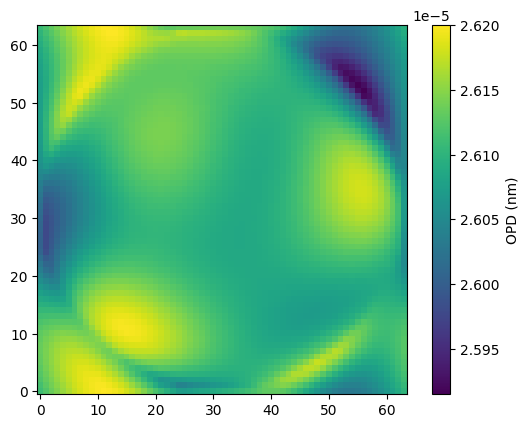

In [18]:
opd_est = fit[-1].reshape((Np,Np))

plt.imshow(opd_est)
plt.colorbar().set_label('OPD (nm)')

In [18]:
piston

Array(2.61092685e-11, dtype=float64)

In [21]:
piston

Array(2.61092685e-05, dtype=float64)

2024-04-22 10:14:13.532232: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


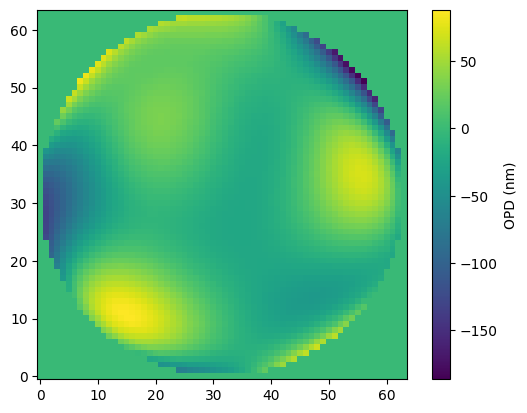

In [19]:
piston = jnp.mean(opd_est[pupil.astype(bool)])
plt.imshow((opd_est-piston)*pupil*1e9)
plt.colorbar().set_label('OPD (nm)')

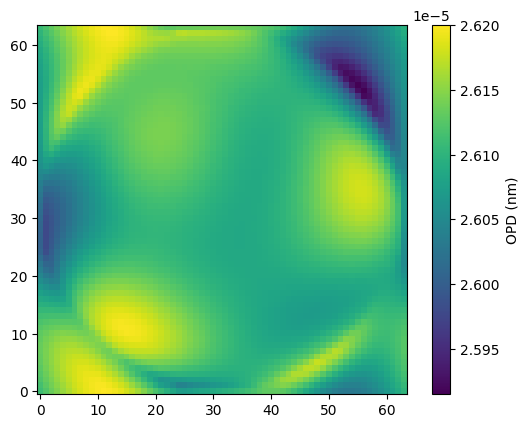

In [19]:
plt.imshow(fit[-1].reshape((Np,Np)))
plt.colorbar().set_label('OPD (nm)')

In [23]:
opd_est.shape

(64, 64)

Now fit phase and amplitude simultaneously

In [13]:
estimator = adpr.Estimation(model, estimate_phase=True, estimate_amplitude=True, maxiter=100, wreg=1e-2)
estimator = adpr.Estimation(model, estimate_phase=True, estimate_amplitude=True, maxiter=100, wreg=1e-2)

In [14]:
fit, err, objvals = estimator.run(psfs)

Text(0, 0.5, 'objective function value')

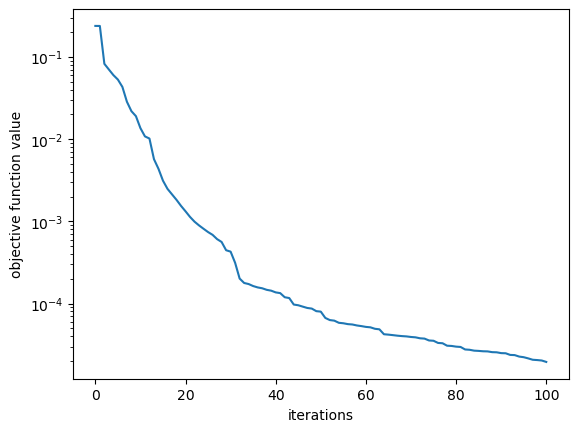

In [15]:
plt.semilogy(objvals)
plt.xlabel('iterations')
plt.ylabel('objective function value')

Text(0.5, 1.0, 'Amplitude')

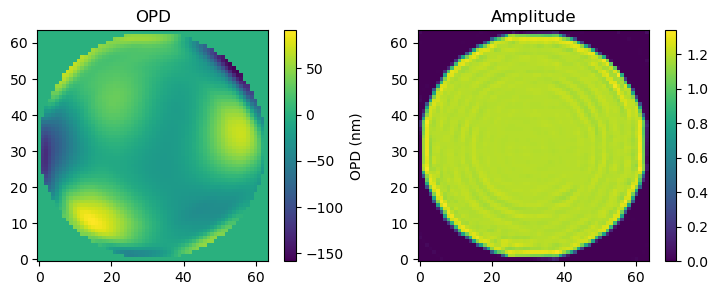

In [16]:
opd_est = fit[-1,:Np*Np].reshape((Np,Np)) * pupil * 1e-6
amp_est = fit[-1,Np*Np:].reshape((Np,Np))


fig, axes = plt.subplots(1,2,figsize=(9,3))

ax = axes[0]
im = ax.imshow(opd_est*1e9)
fig.colorbar(im, ax=ax).set_label('OPD (nm)')
ax.set_title('OPD')

ax = axes[1]
im = ax.imshow(amp_est)
fig.colorbar(im, ax=ax)
ax.set_title('Amplitude')

Here, we'll switch out the optimizer and repeat the estimation

In [17]:
from jaxopt import OptaxSolver
import optax

In [18]:
method_kwargs = {
    'opt' : optax.amsgrad(1e-1, eps=1e-5),
    'tol' : 1e-4 ,
}

estimator = adpr.Estimation(model, estimate_phase=True, estimate_amplitude=False,
                            method=OptaxSolver, method_kwargs=method_kwargs, maxiter=200)

# customize the initial guess a bit
estimator.gauss_init = 0.01
rkey = random.PRNGKey(100)
estimator.init += random.normal(rkey, shape=estimator.init.shape) * 1e-3

In [19]:
fit, err, objvals  = estimator.run(psfs, pupil)

Text(0, 0.5, 'objective function value')

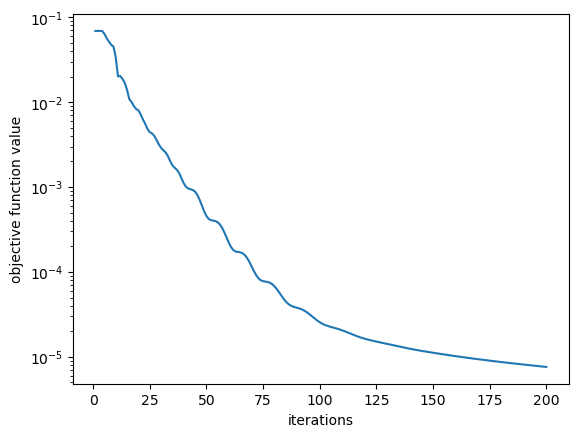

In [20]:
plt.semilogy(objvals)
plt.xlabel('iterations')
plt.ylabel('objective function value')

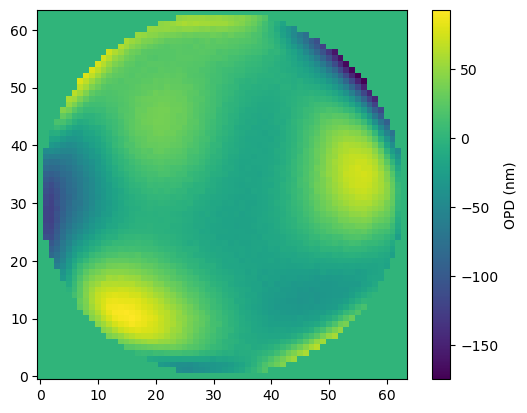

In [21]:
opd_est = fit[-1].reshape((Np,Np)) * pupil * 1e-6

plt.imshow(opd_est*1e9)
plt.colorbar().set_label('OPD (nm)')